# Training Notebook
---
In this notebook, we will train our model to perform data similarity detection.

## Imports & Constants

In [1]:
import os
import sys
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Used to import libraries from an absolute path starting with the project's root
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import importlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.linear_model import LogisticRegression

# Local imports
from src.dataset.similarityVectorizedDataset import SimilarityVectorizedDataset
from src.model.contrastiveModel import ContrastiveLoss, SiameseContrastiveLoss, TextSimilarityLSTM, TextSimilarityDeepSiameseLSTM

In [4]:
BATCH_SIZE = 128
EMBEDDING_DIM = 40
EPOCHS = 25
TRAIN = 0.8
TEST = 0.1
VAL = 0.1
SHUFFLE = True
SEED = 42
LR = 1e-3
TO_SAVE = True

torch.manual_seed(SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

Device used: cuda:0


## Loading data & processing pipeline
We are loading the PyTorch compatible Dataset class and create 3 dataloaders, one per set of data (train, val, test)

In [10]:
def padding_collate(batch):
    """
        Used as a PyTorch collate_fn function in PyTorch dataloaders. 
        Given a batch of vectors of shape (word_count, word_size), 
        make the word_count of each sequence uniform by doing right-side 0 padding.
        
        /!\ The sequences size between batches may vary /!\
    """
    
    max_shape_val = max(
        [
                #b[0] to get X, b[0][0] to get the first sentence of every X, b[0][1] to get the second sentence of every X
            max(b[0][0].shape[0], b[0][1].shape[0]) for b in batch
        ]
    )
    
    X1 = []
    X2 = []
    y = [] 
        
    for i in range(len(batch)):
        
        #batch[i][0] is X, batch[i][1] is y
        x1 = batch[i][0][0]
                    
        if x1.shape[0] < max_shape_val:            
            to_be_padded_shape = (max_shape_val - x1.shape[0], x1.shape[1])
            padding = torch.zeros(to_be_padded_shape)
            x1 = torch.cat((x1, padding), dim=0)
                
        x2 = batch[i][0][1]
        
        if x2.shape[0] < max_shape_val:            
            to_be_padded_shape = (max_shape_val - x2.shape[0], x2.shape[1])
            padding = torch.zeros(to_be_padded_shape)
            x2 = torch.cat((x2, padding), dim=0)
    
        X1.append(x1)
        X2.append(x2)
                
        y.append([batch[i][1]])
    
    X1 = torch.stack(X1)
    X2 = torch.stack(X2)
    
    return (X1, X2), torch.FloatTensor(y)


In [13]:
dataset = SimilarityVectorizedDataset()

# Data preparation 
dataset_size = len(dataset)
indices = list(range(dataset_size))

val_split = int(np.floor(VAL * dataset_size))
test_split = int(np.floor(TEST * dataset_size))

if SHUFFLE:
    np.random.seed(SEED)
    np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[val_split+test_split:], indices[:val_split], indices[val_split:val_split+test_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

num_train_batch = int(np.ceil(TRAIN * dataset_size / BATCH_SIZE))
num_val_batch = int(np.ceil(VAL * dataset_size / BATCH_SIZE))
num_test_batch = int(np.ceil(TEST * dataset_size / BATCH_SIZE))

print("Creating dataloaders..")

dataloader_train = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    collate_fn = padding_collate,
    sampler = train_sampler
)

dataloader_val = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    collate_fn = padding_collate,
    sampler = val_sampler
)

dataloader_test = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = test_sampler
)

Creating dataloaders..


## Part I: Training the distance model

In [17]:
len(train_indices), len(val_indices), len(test_indices)

(323404, 40425, 40425)

### Instantiating model, loss and optimizer

In [5]:
import src.model.contrastiveModel
importlib.reload(src.model.contrastiveModel)

<module 'src.model.contrastiveModel' from 'C:\\Users\\thoma\\OneDrive\\Documents\\GitHub\\Text-Semantic-Similarity\\src\\model\\contrastiveModel.py'>

In [6]:
model = src.model.contrastiveModel.TextSimilarityDeepSiameseLSTM(embedding_dim = EMBEDDING_DIM)
model = model.cuda()
model.train()

contrastive_loss = src.model.contrastiveModel.SiameseContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

### Training & Validation loops

In [7]:
for i in range(EPOCHS):

    print(f"Epochs {i}")
    n = 1
    total_loss = 0
    total_duration = 0
    t0 = time.time()
    total_timesteps = len(dataloader_train)


    for local_batch, local_labels in dataloader_train:
        model.zero_grad()

        # Transfer to GPU
        local_batch_X1, local_batch_X2, local_labels = local_batch[0].to(device), local_batch[1].to(device), local_labels.to(device)

        preds = model(local_batch_X1, local_batch_X2)

        # Compute the loss, gradients, and update the parameters by
        #loss = loss_function(preds, local_labels)
        loss = contrastive_loss(preds, local_labels)
        loss.backward()
        optimizer.step()

        # Statistics to follow progress
        total_loss += loss.item()
        duration = time.time() - t0
        total_duration += duration
        total_duration = round(total_duration, 2)

        estimated_duration_left = round((total_duration / n) * (total_timesteps), 2)

        print(f"\r Epochs {i} - Loss: {total_loss/n} - Acc: {0} - Batch: {n}/{num_train_batch} - Dur: {total_duration}s/{estimated_duration_left}s", end="")
        n+=1
        t0 = time.time()

    print("\n")

    # End of epochs validation

    n = 1
    total_loss = 0
    with torch.no_grad():
        model.eval()
        for local_batch, local_labels in dataloader_val:
            # Transfer to GPU
            local_batch_X1, local_batch_X2, local_labels = local_batch[0].to(device), local_batch[1].to(device), local_labels.to(device)

            preds = model(local_batch_X1, local_batch_X2)

            loss = contrastive_loss(preds, local_labels)

            total_loss += loss.item()

            acc=0
            print(f"\r Epochs {i} - Val_loss: {total_loss/n} - Batch: {n}/{num_val_batch}", end="")
            n+=1

        if TO_SAVE:
            date = datetime.now().strftime("%m_%d_%H_%M_%S" )
            torch.save(model.state_dict(), f"siamese_lstm_sequence_{date}_epoch{i}.pt")

        model.train()
    print("\n---")

Epochs 0


NameError: name 'dataloader_train' is not defined

In [13]:
date = datetime.now().strftime("%m_%d_%H_%M_%S" )
torch.save(model.state_dict(), f"siamese_lstm_sequence_{date}_epoch{i}.pt")

## Part II: Training the distance classifier
### Dataloaders creation

In [8]:
def model_and_titles_to_distance_dataset(model, dataloader):
    """
    Given a similarity learning model and a dataloader, transforms the data of the dataloader in the shape of a distance dataset.
    The distances are computed using the model. We then use the target variables to train a linear model to classify the distances
    to 2 different classes: similar or dissimilar.
    """



    X = []
    y = []
    
    n = 1
    
    total_duration = 0
    total_steps = len(dataloader)
    
    model.eval()
    
    for local_batch, local_labels in dataloader:
        
        t0 = time.time()
        
        # Transfer to GPU
        local_batch_X1, local_batch_X2, local_labels = local_batch[0].to(device), local_batch[1].to(device), local_labels.to(device)

        preds = model(local_batch_X1, local_batch_X2)
        
        with torch.no_grad():
            # Transfering distances and labels to cpu
            distances_cpu = preds.cpu().numpy().reshape(-1, 1)
            labels = torch.flatten(local_labels).cpu().numpy().reshape(-1, 1)
            # Fitting logreg
            X.append(distances_cpu)
            y.append(labels)
        
        duration = time.time() - t0
        
        total_duration += duration
        
        per_step_mean_duration = total_duration / n
        rest_of_time = per_step_mean_duration * (total_steps)
        
        n+=1
        print(f"\r{n}-{total_steps} (ETA: {total_duration}/{rest_of_time}s)", end="")
        
    model.train()
        
    X = np.array(X).flatten().reshape(-1, 1)
    y = np.array(y).flatten()
    
    return X, y


In [9]:
dataloader_train = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = train_sampler
)

dataloader_val = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = val_sampler
)

dataloader_test = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = test_sampler
)

In [10]:
print("Generating training dataset...")
X_train, y_train = model_and_titles_to_distance_dataset(model, dataloader_train)

print("Generating validation dataset...")
X_test, y_test = model_and_titles_to_distance_dataset(model, dataloader_test)

print("Generating test dataset...")
X_val, y_val = model_and_titles_to_distance_dataset(model, dataloader_val)

Generating training dataset...
323405-323404 (ETA: 2527.3489344120026/2527.3489344120026s)Generating validation dataset...
80851-80850 (ETA: 643.5618054866791/643.5618054866791s))Generating test dataset...
40426-40425 (ETA: 311.65931963920593/311.65931963920593s)

In [11]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

train_acc = logreg.score(X_train, y_train)
val_acc = logreg.score(X_val, y_val)
test_acc = logreg.score(X_test, y_test)

print(f"\nFinal perfs: {train_acc} - {val_acc} - {test_acc}")


Final perfs: 0.8791202335159738 - 0.787334570191713 - 0.7888682745825603


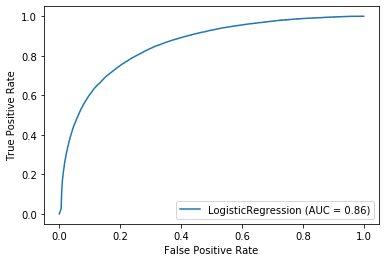

In [12]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(logreg, X_test, y_test)

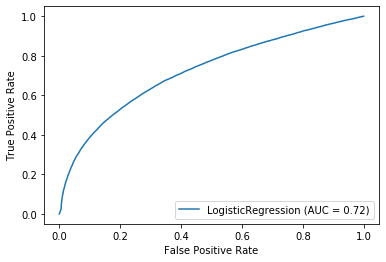

In [73]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(logreg, X_test, y_test)

In [18]:
import src.model.contrastiveModel
importlib.reload(src.model.contrastiveModel)

<module 'src.model.contrastiveModel' from 'C:\\Users\\thoma\\OneDrive\\Documents\\GitHub\\Text-Semantic-Similarity\\src\\model\\contrastiveModel.py'>

In [19]:
model = src.model.contrastiveModel.TextSimilarityDeepSiameseLSTM(embedding_dim = EMBEDDING_DIM)
model.cuda()
model.train()

contrastive_loss = src.model.contrastiveModel.SiameseContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

### Training & Validation loops

In [20]:
for i in range(EPOCHS):

    print(f"Epochs {i}")
    n = 1
    total_loss = 0
    total_duration = 0
    t0 = time.time()
    total_timesteps = len(dataloader_train)


    for local_batch, local_labels in dataloader_train:
        model.zero_grad()

        # Transfer to GPU
        local_batch_X1, local_batch_X2, local_labels = local_batch[0].to(device), local_batch[1].to(device), local_labels.to(device)

        preds = model(local_batch_X1, local_batch_X2)

        # Compute the loss, gradients, and update the parameters by
        #loss = loss_function(preds, local_labels)
        loss = contrastive_loss(preds, local_labels)
        loss.backward()
        optimizer.step()

        # Statistics to follow progress
        total_loss += loss.item()
        duration = time.time() - t0
        total_duration += duration
        total_duration = round(total_duration, 2)

        estimated_duration_left = round((total_duration / n) * (total_timesteps), 2)

        print(f"\r Epochs {i} - Loss: {total_loss/n} - Acc: {0} - Batch: {n}/{num_train_batch} - Dur: {total_duration}s/{estimated_duration_left}s", end="")
        n+=1
        t0 = time.time()

    print("\n")

    # End of epochs validation

    n = 1
    total_loss = 0
    with torch.no_grad():
        model.eval()
        for local_batch, local_labels in dataloader_val:
            # Transfer to GPU
            local_batch_X1, local_batch_X2, local_labels = local_batch[0].to(device), local_batch[1].to(device), local_labels.to(device)

            preds = model(local_batch_X1, local_batch_X2)

            loss = contrastive_loss(preds, local_labels)

            total_loss += loss.item()

            acc=0
            print(f"\r Epochs {i} - Val_loss: {total_loss/n} - Batch: {n}/{num_val_batch}", end="")
            n+=1

        if TO_SAVE:
            date = datetime.now().strftime("%m_%d_%H_%M_%S" )
            torch.save(model.state_dict(), f"siamese_lstm_sequence_{date}_epoch{i}.pt")

        model.train()
    print("\n---")

Epochs 0
 Epochs 0 - Loss: 0.47034857881177683 - Acc: 0 - Batch: 2527/2527 - Dur: 633.88s/633.88s

 Epochs 0 - Val_loss: 0.4319848928459083 - Batch: 316/3166
---
Epochs 1
 Epochs 1 - Loss: 0.4160456503385794 - Acc: 0 - Batch: 2527/2527 - Dur: 287.31s/287.31ss

 Epochs 1 - Val_loss: 0.41224280065750774 - Batch: 316/316
---
Epochs 2
 Epochs 2 - Loss: 0.39695531133375106 - Acc: 0 - Batch: 2527/2527 - Dur: 282.76s/282.76s

 Epochs 2 - Val_loss: 0.3934259812665891 - Batch: 316/3166
---
Epochs 3
 Epochs 3 - Loss: 0.3830358907550892 - Acc: 0 - Batch: 2527/2527 - Dur: 286.57s/286.57ss

 Epochs 3 - Val_loss: 0.37925554689350005 - Batch: 316/316
---
Epochs 4
 Epochs 4 - Loss: 0.3709938465770545 - Acc: 0 - Batch: 2527/2527 - Dur: 281.83s/281.83ss

 Epochs 4 - Val_loss: 0.3712030093692526 - Batch: 316/3166
---
Epochs 5
 Epochs 5 - Loss: 0.36151552555893174 - Acc: 0 - Batch: 2527/2527 - Dur: 282.7s/282.7sss

 Epochs 5 - Val_loss: 0.3670369802585131 - Batch: 316/3166
---
Epochs 6
 Epochs 6 - Loss: 0

KeyboardInterrupt: 

In [ ]:
date = datetime.now().strftime("%m_%d_%H_%M_%S" )
torch.save(model.state_dict(), f"siamese_smaller_lstm_sequence_{date}_epoch{i}.pt")

## Part II: Training the distance classifier
### Dataloaders creation

In [21]:
def model_and_titles_to_distance_dataset(model, dataloader):
    """
    Given a similarity learning model and a dataloader, transforms the data of the dataloader in the shape of a distance dataset.
    The distances are computed using the model. We then use the target variables to train a linear model to classify the distances
    to 2 different classes: similar or dissimilar.
    """



    X = []
    y = []
    
    n = 1
    
    total_duration = 0
    total_steps = len(dataloader)
    
    model.eval()
    
    for local_batch, local_labels in dataloader:
        
        t0 = time.time()
        
        # Transfer to GPU
        local_batch_X1, local_batch_X2, local_labels = local_batch[0].to(device), local_batch[1].to(device), local_labels.to(device)

        preds = model(local_batch_X1, local_batch_X2)
        
        with torch.no_grad():
            # Transfering distances and labels to cpu
            distances_cpu = preds.cpu().numpy().reshape(-1, 1)
            labels = torch.flatten(local_labels).cpu().numpy().reshape(-1, 1)
            # Fitting logreg
            X.append(distances_cpu)
            y.append(labels)
        
        duration = time.time() - t0
        
        total_duration += duration
        
        per_step_mean_duration = total_duration / n
        rest_of_time = per_step_mean_duration * (total_steps)
        
        n+=1
        print(f"\r{n}-{total_steps} (ETA: {total_duration}/{rest_of_time}s)", end="")
        
    model.train()
        
    X = np.array(X).flatten().reshape(-1, 1)
    y = np.array(y).flatten()
    
    return X, y


In [22]:
dataloader_train = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = train_sampler
)

dataloader_val = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = val_sampler
)

dataloader_test = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = test_sampler
)

In [23]:
print("Generating training dataset...")
X_train, y_train = model_and_titles_to_distance_dataset(model, dataloader_train)

print("Generating validation dataset...")
X_test, y_test = model_and_titles_to_distance_dataset(model, dataloader_test)

print("Generating test dataset...")
X_val, y_val = model_and_titles_to_distance_dataset(model, dataloader_val)

Generating training dataset...
323405-323404 (ETA: 2862.318431854248/2862.318431854248s)s)Generating validation dataset...
40426-40425 (ETA: 324.6666724681854/324.6666724681855s)Generating test dataset...
40426-40425 (ETA: 326.08153319358826/326.08153319358826s)

In [24]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

train_acc = logreg.score(X_train, y_train)
val_acc = logreg.score(X_val, y_val)
test_acc = logreg.score(X_test, y_test)

print(f"\nFinal perfs: {train_acc} - {val_acc} - {test_acc}")


Final perfs: 0.7894120047989511 - 0.7616326530612245 - 0.7670995670995671


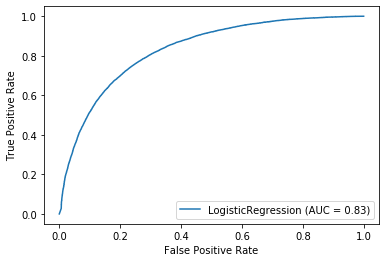

In [25]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(logreg, X_test, y_test)